In [2]:
# ---------------------------
# 1) Importações e checagem de GPU
# ---------------------------
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np

print("TensorFlow:", tf.__version__)
print("GPUs disponíveis:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.19.0
GPUs disponíveis: []


In [3]:
# ---------------------------
# 2) Baixar / carregar o dataset Cats vs Dogs
# ---------------------------
(ds_train, ds_test), ds_info = tfds.load(
    "cats_vs_dogs",
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)

# Ver nomes das classes (ex.: ['cat','dog'])
print("Classes:", ds_info.features['label'].names)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.HMVLMC_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Classes: ['cat', 'dog']


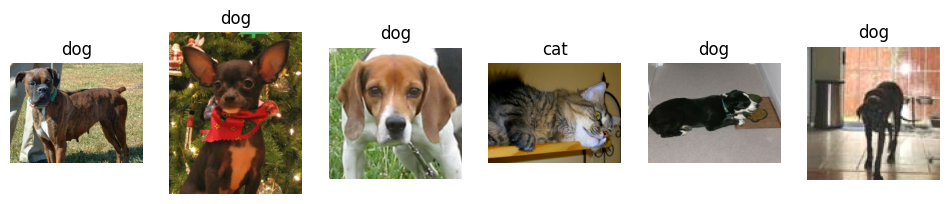

In [4]:
# ---------------------------
# 3) Mostrar algumas imagens originais (antes do preprocess) — para você inspecionar a base
# ---------------------------
def show_samples(dataset, n=6):
    plt.figure(figsize=(12,6))
    for i, (image, label) in enumerate(dataset.take(n)):
        plt.subplot(1, n, i+1)
        plt.imshow(image.numpy().astype('uint8'))
        plt.title(ds_info.features['label'].names[label.numpy()])
        plt.axis('off')
    plt.show()

# Mostra 6 imagens do treino
show_samples(ds_train, n=6)

In [5]:
# ---------------------------
# 4) Função de pré-processamento (redimensiona e aplica preprocess_input do VGG16)
# ---------------------------
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    # 1) redimensiona para 150x150
    image = tf.image.resize(image, (150, 150))
    # 2) garante float32 (preprocess_input espera valores no intervalo 0-255)
    image = tf.cast(image, tf.float32)
    # 3) aplica o preprocess específico do VGG16 (subtração de média, troca de canais se necessário)
    image = preprocess_input(image)
    return image, label

# Monta os pipelines de treino e validação (shuffle apenas no treino)
train_ds = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE).shuffle(1000).batch(32).prefetch(AUTOTUNE)
val_ds = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)

In [6]:
# ---------------------------
# 5) Construir o modelo (Transfer Learning com VGG16)
# ---------------------------
# Carrega base VGG16 sem a "top" (camadas finais)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

# Congela todas as camadas para começar (não treinar pesos da base agora)
base_model.trainable = False

# Monta a cabeça do classificador em cima do base_model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),   # reduz dimensionalidade sem explodir parâmetros (melhor que Flatten)
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # saída binária: 0 ou 1
])

# Compilação
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
# ---------------------------
# 6) Treinar o modelo (congelando a base)
# ---------------------------
epochs = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
 36/582 ━━━━━━━━━━━━━━━━━━━━ 48:13 5s/step - accuracy: 0.7771 - loss: 2.1051

KeyboardInterrupt: 

In [ ]:
# ---------------------------
# 7) Avaliar e plotar curvas
# ---------------------------
loss, acc = model.evaluate(val_ds)
print(f"Acurácia no conjunto de validação: {acc*100:.2f}%")

# Plota curvas de acurácia e perda
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Acurácia')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

plt.show()

In [ ]:
# ---------------------------
# 8) Salvar o modelo treinado
# ---------------------------
model.save('transfer_vgg16_cats_vs_dogs.h5')
print("Modelo salvo: transfer_vgg16_cats_vs_dogs.h5")

In [ ]:
# ---------------------------
# 9) (Opcional) Fine-tuning — descongelar algumas camadas e treinar com LR pequeno
# ---------------------------
# Descongela o modelo base parcialmente para ajustar pesos finos
base_model.trainable = True

# Opcional: mantenha congeladas as primeiras camadas e treine apenas as últimas
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Recompile com uma taxa de aprendizado pequena
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Treine mais algumas épocas (cuidado com overfitting)
fine_history = model.fit(train_ds, validation_data=val_ds, epochs=3)